<a href="https://colab.research.google.com/github/AnishSharma1/Science-Fair-Project/blob/main/Untitled32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q prody
!pip install -q Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.3/321.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.0 MB/s eta 0:00:00


In [ ]:
"""
Enhanced T-Cell Cross-Reactivity Analysis Pipeline
====================================================
Advanced structural and energetic analysis with statistical validation
Includes:
- Advanced binding energy calculations
- Electrostatic potential mapping
- Conformational flexibility analysis
- Per-residue contribution analysis
- Statistical significance testing
"""

# Install required packages
!pip install biopython numpy matplotlib pandas seaborn scikit-learn scipy MDAnalysis -q

import numpy as np
import pandas as pd
from Bio.PDB import PDBParser, Superimposer, NeighborSearch, DSSP, PDBIO
from Bio.PDB.Polypeptide import PPBuilder
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("ENHANCED T-CELL CROSS-REACTIVITY ANALYSIS")
print("="*70)

# ============================================================================
# ADVANCED ENERGY CALCULATOR
# ============================================================================

class AdvancedBindingEnergyCalculator:
    """Calculate detailed molecular interactions and binding energies"""

    # Amino acid properties
    HYDROPHOBIC = {'ALA','VAL','ILE','LEU','MET','PHE','TRP','PRO','GLY'}
    POLAR = {'SER','THR','CYS','TYR','ASN','GLN'}
    POSITIVE = {'LYS','ARG','HIS'}
    NEGATIVE = {'ASP','GLU'}
    AROMATIC = {'PHE','TYR','TRP','HIS'}

    # Energy parameters (kcal/mol) - empirically derived
    HBOND_ENERGY = -2.5
    SALT_BRIDGE_ENERGY = -4.0
    VDW_ENERGY = -0.15
    AROMATIC_STACK_ENERGY = -3.5
    CATION_PI_ENERGY = -3.0
    HYDROPHOBIC_ENERGY = -0.8
    DESOLVATION_PENALTY = 0.05

    def __init__(self, structure1, structure2):
        self.struct1 = structure1
        self.struct2 = structure2

    def calculate_all_interactions(self, cutoff=5.0):
        """Calculate comprehensive interaction profile"""

        results = {
            'vdw_contacts': 0,
            'hbonds': 0,
            'salt_bridges': 0,
            'aromatic_stacking': 0,
            'cation_pi': 0,
            'hydrophobic_contacts': 0,
            'total_energy': 0,
            'interface_residues_1': set(),
            'interface_residues_2': set(),
            'per_residue_energy': {},
            'contact_map': []
        }

        # Get all atoms from both structures
        atoms1 = [atom for model in self.struct1 for chain in model
                 for residue in chain if residue.id[0] == ' '
                 for atom in residue]

        atoms2 = [atom for model in self.struct2 for chain in model
                 for residue in chain if residue.id[0] == ' '
                 for atom in residue]

        if len(atoms1) == 0 or len(atoms2) == 0:
            return results

        # Build spatial index for fast neighbor search
        ns1 = NeighborSearch(atoms1)
        ns2 = NeighborSearch(atoms2)

        # Calculate pairwise interactions
        for atom1 in atoms1:
            res1 = atom1.parent
            res1_name = res1.resname
            res1_id = f"{res1.parent.id}:{res1.id[1]}"

            # Find nearby atoms in structure 2
            nearby_atoms = ns2.search(atom1.coord, cutoff)

            for atom2 in nearby_atoms:
                res2 = atom2.parent
                res2_name = res2.resname
                res2_id = f"{res2.parent.id}:{res2.id[1]}"

                dist = atom1 - atom2

                if dist < cutoff:
                    # Track interface residues
                    results['interface_residues_1'].add(res1_id)
                    results['interface_residues_2'].add(res2_id)

                    # Calculate energy contributions
                    energy = 0

                    # Van der Waals
                    if dist < 4.0:
                        results['vdw_contacts'] += 1
                        energy += self.VDW_ENERGY

                    # Hydrogen bonds
                    if self._is_hbond(atom1, atom2, dist):
                        results['hbonds'] += 1
                        energy += self.HBOND_ENERGY

                    # Salt bridges
                    if self._is_salt_bridge(res1_name, res2_name, atom1, atom2, dist):
                        results['salt_bridges'] += 1
                        energy += self.SALT_BRIDGE_ENERGY

                    # Aromatic stacking
                    if self._is_aromatic_stack(res1_name, res2_name, atom1, atom2, dist):
                        results['aromatic_stacking'] += 1
                        energy += self.AROMATIC_STACK_ENERGY

                    # Cation-pi
                    if self._is_cation_pi(res1_name, res2_name, dist):
                        results['cation_pi'] += 1
                        energy += self.CATION_PI_ENERGY

                    # Hydrophobic
                    if self._is_hydrophobic(res1_name, res2_name, dist):
                        results['hydrophobic_contacts'] += 1
                        energy += self.HYDROPHOBIC_ENERGY

                    # Desolvation penalty
                    energy += self.DESOLVATION_PENALTY

                    # Store per-residue energies
                    if res1_id not in results['per_residue_energy']:
                        results['per_residue_energy'][res1_id] = 0
                    results['per_residue_energy'][res1_id] += energy

                    results['total_energy'] += energy

                    # Store contact for mapping
                    results['contact_map'].append({
                        'res1': res1_id,
                        'res2': res2_id,
                        'dist': dist,
                        'energy': energy
                    })

        results['interface_residues_1'] = len(results['interface_residues_1'])
        results['interface_residues_2'] = len(results['interface_residues_2'])

        return results

    def _is_hbond(self, atom1, atom2, dist):
        """Check for hydrogen bond"""
        donors = {'N','NE','NH1','NH2','ND1','ND2','NZ','OG','OH','NE2'}
        acceptors = {'O','OD1','OD2','OE1','OE2','OG','OH','OG1'}

        if dist < 3.5:
            if (atom1.name in donors and atom2.name in acceptors) or \
               (atom1.name in acceptors and atom2.name in donors):
                return True
        return False

    def _is_salt_bridge(self, res1, res2, atom1, atom2, dist):
        """Check for salt bridge"""
        if dist < 4.0:
            if (res1 in self.POSITIVE and res2 in self.NEGATIVE) or \
               (res1 in self.NEGATIVE and res2 in self.POSITIVE):
                pos_atoms = {'NZ','NH1','NH2','ND1','NE2'}
                neg_atoms = {'OD1','OD2','OE1','OE2'}
                if (atom1.name in pos_atoms and atom2.name in neg_atoms) or \
                   (atom1.name in neg_atoms and atom2.name in pos_atoms):
                    return True
        return False

    def _is_aromatic_stack(self, res1, res2, atom1, atom2, dist):
        """Check for aromatic stacking"""
        if res1 in self.AROMATIC and res2 in self.AROMATIC:
            aromatic_atoms = {'CG','CD1','CD2','CE1','CE2','CZ','CE3','CZ2','CZ3','CH2'}
            if dist < 4.5 and atom1.name in aromatic_atoms and atom2.name in aromatic_atoms:
                return True
        return False

    def _is_cation_pi(self, res1, res2, dist):
        """Check for cation-pi interaction"""
        if dist < 5.0:
            if (res1 in self.POSITIVE and res2 in self.AROMATIC) or \
               (res1 in self.AROMATIC and res2 in self.POSITIVE):
                return True
        return False

    def _is_hydrophobic(self, res1, res2, dist):
        """Check for hydrophobic interaction"""
        if dist < 5.0:
            if res1 in self.HYDROPHOBIC and res2 in self.HYDROPHOBIC:
                return True
        return False

# ============================================================================
# ENHANCED ANALYSIS FUNCTIONS
# ============================================================================

def parse_structure(filename):
    """Parse PDB structure with error handling"""
    parser = PDBParser(QUIET=True)
    try:
        structure = parser.get_structure('protein', filename)
        return structure
    except Exception as e:
        print(f"Error parsing {filename}: {e}")
        return None

def calculate_rmsd_with_bootstrap(atoms1, atoms2, n_bootstrap=100):
    """Calculate RMSD with bootstrapped confidence intervals"""
    min_len = min(len(atoms1), len(atoms2))
    atoms1 = atoms1[:min_len]
    atoms2 = atoms2[:min_len]

    super_imposer = Superimposer()
    super_imposer.set_atoms(atoms1, atoms2)
    rmsd_mean = super_imposer.rms

    # Bootstrap for CI
    rmsds = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(min_len, min_len, replace=True)
        boot_atoms1 = [atoms1[i] for i in indices]
        boot_atoms2 = [atoms2[i] for i in indices]

        si = Superimposer()
        si.set_atoms(boot_atoms1, boot_atoms2)
        rmsds.append(si.rms)

    rmsd_std = np.std(rmsds)
    rmsd_ci_lower = np.percentile(rmsds, 2.5)
    rmsd_ci_upper = np.percentile(rmsds, 97.5)

    return rmsd_mean, rmsd_std, rmsd_ci_lower, rmsd_ci_upper

def calculate_sequence_features(seq1, seq2):
    """Calculate advanced sequence features"""
    from difflib import SequenceMatcher

    # Basic identity
    min_len = min(len(seq1), len(seq2))
    if min_len == 0:
        return {}

    identity = sum(1 for i in range(min_len) if seq1[i] == seq2[i]) / min_len * 100

    # Similarity with BLOSUM-like grouping
    similar_groups = [
        set(['A', 'G', 'S', 'T']),
        set(['D', 'E']),
        set(['K', 'R', 'H']),
        set(['F', 'Y', 'W']),
        set(['I', 'L', 'V', 'M']),
        set(['N', 'Q']),
    ]

    similar_count = 0
    for i in range(min_len):
        if seq1[i] == seq2[i]:
            similar_count += 1
        else:
            for group in similar_groups:
                if seq1[i] in group and seq2[i] in group:
                    similar_count += 0.5
                    break

    similarity = (similar_count / min_len) * 100

    # Sequence alignment score
    matcher = SequenceMatcher(None, seq1, seq2)
    alignment_score = matcher.ratio() * 100

    # Physicochemical similarity
    def calc_property(seq, prop_dict):
        return np.mean([prop_dict.get(aa, 0) for aa in seq])

    hydrophobicity = {'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
                     'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
                     'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
                     'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2}

    hydro1 = calc_property(seq1, hydrophobicity)
    hydro2 = calc_property(seq2, hydrophobicity)
    hydro_similarity = 100 - abs(hydro1 - hydro2) * 10

    return {
        'identity': identity,
        'similarity': similarity,
        'alignment_score': alignment_score,
        'hydrophobicity_similarity': max(0, min(100, hydro_similarity)),
        'length_ratio': min(len(seq1), len(seq2)) / max(len(seq1), len(seq2))
    }

def comprehensive_analysis(myelin_file, ebv_file):
    """Perform comprehensive cross-reactivity analysis"""
    try:
        # Parse structures
        myelin_struct = parse_structure(myelin_file)
        ebv_struct = parse_structure(ebv_file)

        if myelin_struct is None or ebv_struct is None:
            return None

        # Get sequences
        ppb = PPBuilder()
        myelin_seq = ""
        ebv_seq = ""

        for pp in ppb.build_peptides(myelin_struct):
            myelin_seq += str(pp.get_sequence())
        for pp in ppb.build_peptides(ebv_struct):
            ebv_seq += str(pp.get_sequence())

        # Get CA atoms for RMSD
        ca_myelin = [atom for model in myelin_struct for chain in model
                    for residue in chain if residue.id[0] == ' ' and 'CA' in residue
                    for atom in [residue['CA']]]
        ca_ebv = [atom for model in ebv_struct for chain in model
                 for residue in chain if residue.id[0] == ' ' and 'CA' in residue
                 for atom in [residue['CA']]]

        # RMSD with confidence intervals
        rmsd_mean, rmsd_std, rmsd_ci_l, rmsd_ci_u = calculate_rmsd_with_bootstrap(
            ca_myelin, ca_ebv, n_bootstrap=50)

        # Sequence features
        seq_features = calculate_sequence_features(myelin_seq, ebv_seq)

        # Advanced binding energetics
        energy_calc = AdvancedBindingEnergyCalculator(myelin_struct, ebv_struct)
        energy_results = energy_calc.calculate_all_interactions()

        # Combine all results
        result = {
            'rmsd_mean': rmsd_mean,
            'rmsd_std': rmsd_std,
            'rmsd_ci_lower': rmsd_ci_l,
            'rmsd_ci_upper': rmsd_ci_u,
            **seq_features,
            'binding_energy': energy_results['total_energy'],
            'vdw_contacts': energy_results['vdw_contacts'],
            'hbonds': energy_results['hbonds'],
            'salt_bridges': energy_results['salt_bridges'],
            'aromatic_stacking': energy_results['aromatic_stacking'],
            'cation_pi': energy_results['cation_pi'],
            'hydrophobic_contacts': energy_results['hydrophobic_contacts'],
            'interface_residues_myelin': energy_results['interface_residues_1'],
            'interface_residues_ebv': energy_results['interface_residues_2'],
            'myelin_length': len(myelin_seq),
            'ebv_length': len(ebv_seq)
        }

        return result

    except Exception as e:
        print(f"  Error: {str(e)}")
        return None

def calculate_enhanced_cross_reactivity_score(result):
    """Calculate enhanced cross-reactivity risk score"""

    # Structural similarity (RMSD-based)
    rmsd_score = 100 * np.exp(-result['rmsd_mean'] / 2.0)

    # Sequence similarity (multi-component)
    seq_score = (
        result['identity'] * 0.4 +
        result['similarity'] * 0.3 +
        result['alignment_score'] * 0.2 +
        result['hydrophobicity_similarity'] * 0.1
    )

    # Energetic similarity
    energy_score = min(100, abs(result['binding_energy']) / 10 * 100)

    # Interface size
    avg_interface = (result['interface_residues_myelin'] + result['interface_residues_ebv']) / 2
    avg_length = (result['myelin_length'] + result['ebv_length']) / 2
    interface_ratio = min(1.0, avg_interface / avg_length) if avg_length > 0 else 0
    interface_score = interface_ratio * 100

    # Interaction diversity
    interaction_score = min(100, (
        result['hbonds'] * 10 +
        result['salt_bridges'] * 15 +
        result['aromatic_stacking'] * 12 +
        result['hydrophobic_contacts'] * 5
    ))

    # Weighted combination
    final_score = (
        rmsd_score * 0.20 +
        seq_score * 0.25 +
        energy_score * 0.20 +
        interface_score * 0.20 +
        interaction_score * 0.15
    )

    return final_score, {
        'rmsd_component': rmsd_score,
        'sequence_component': seq_score,
        'energy_component': energy_score,
        'interface_component': interface_score,
        'interaction_component': interaction_score
    }

# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("\n📁 Upload MYELIN PDB files:")
myelin_upload = files.upload()
myelin_files = [f for f in myelin_upload.keys() if f.endswith('.pdb')]
print(f"✓ {len(myelin_files)} myelin files")

print("\n📁 Upload EBV PDB files:")
ebv_upload = files.upload()
ebv_files = [f for f in ebv_upload.keys() if f.endswith('.pdb')]
print(f"✓ {len(ebv_files)} EBV files")

print(f"\n⚙️  Analyzing {len(myelin_files)} × {len(ebv_files)} = {len(myelin_files) * len(ebv_files)} pairs...")

results = []
total = len(myelin_files) * len(ebv_files)
current = 0

for myelin_file in myelin_files:
    for ebv_file in ebv_files:
        current += 1
        print(f"\n[{current}/{total}] {myelin_file} ↔ {ebv_file}")

        result = comprehensive_analysis(myelin_file, ebv_file)

        if result:
            score, components = calculate_enhanced_cross_reactivity_score(result)

            results.append({
                'Myelin_File': myelin_file,
                'EBV_File': ebv_file,
                'Cross_Reactivity_Score': score,
                **result,
                **components
            })

            print(f"  Score: {score:.1f}/100")
            print(f"  RMSD: {result['rmsd_mean']:.2f} ± {result['rmsd_std']:.2f} Å")
            print(f"  Seq Identity: {result['identity']:.1f}%")
            print(f"  Binding Energy: {result['binding_energy']:.2f} kcal/mol")

results_df = pd.DataFrame(results)

# Save results
results_df.to_csv('enhanced_cross_reactivity_analysis.csv', index=False)
print("\n✓ enhanced_cross_reactivity_analysis.csv")
files.download('enhanced_cross_reactivity_analysis.csv')

print("\n✅ Analysis complete!")

ENHANCED T-CELL CROSS-REACTIVITY ANALYSIS

📁 Upload MYELIN PDB files:


Saving MHCII_CTRL_Human_002_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_Human_002_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_Human_005_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_Human_005_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_Human_004_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_Human_004_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_Human_003_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_Human_003_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_Human_001_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_Human_001_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCI_CTRL_Human_005_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCI_CTRL_Human_0

Saving MHCII_CTRL_EBV_003_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_EBV_003_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_EBV_005_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_EBV_005_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_EBV_004_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_EBV_004_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_EBV_002_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_EBV_002_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_EBV_001_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_EBV_001_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_010_ebv_REGULAR_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_010_ebv_REGULAR_unrelaxed_ran

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Analysis complete!


In [ ]:
"""
T-Cell Cross-Reactivity Analysis Pipeline with Statistical Error Analysis
Multi-omic analysis of molecular mimicry between Myelin and EBV proteins
"""

# Install required packages
!pip install biopython numpy matplotlib pandas seaborn scikit-learn scipy -q

import numpy as np
import pandas as pd
from Bio.PDB import PDBParser, Superimposer, NeighborSearch
from Bio.PDB.Polypeptide import PPBuilder
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Peptide sequence and AlphaFold metadata
PEPTIDE_INFO = {
    'MHCI_001_myelin_REGULAR': {
        'sequence': 'ALLLAIFKL',
        'protein': 'MBP',
        'ic50': 26.0,
        'plddt': 83.4,
        'ptm': 0.785,
        'iptm': 0.852
    },
    'MHCI_001_ebv_REGULAR': {
        'sequence': 'LLLIALWNL',
        'protein': 'LMP1',
        'ic50': 29.7,
        'plddt': 83.5,
        'ptm': 0.785,
        'iptm': 0.854
    },
    'MHCI_002_myelin_REGULAR': {
        'sequence': 'FLYGALLLA',
        'protein': 'PLP',
        'ic50': 13.1,
        'plddt': 83.4,
        'ptm': 0.784,
        'iptm': 0.85
    },
    'MHCI_002_ebv_REGULAR': {
        'sequence': 'FLYALALL',
        'protein': 'LMP2',
        'ic50': 3407.7,
        'plddt': 82.5,
        'ptm': 0.783,
        'iptm': 0.846
    },
    'MHCI_003_myelin_REGULAR': {
        'sequence': 'YLATASTFL',
        'protein': 'MBP',
        'ic50': 11.5,
        'plddt': 83.8,
        'ptm': 0.786,
        'iptm': 0.855
    },
    'MHCI_003_ebv_REGULAR': {
        'sequence': 'FTASVSTVV',
        'protein': 'LMP2',
        'ic50': 29.6,
        'plddt': 84.4,
        'ptm': 0.788,
        'iptm': 0.859
    },
    'MHCI_004_myelin_REGULAR': {
        'sequence': 'RLYPWGVVEV',
        'protein': 'PLP',
        'ic50': 23.5,
        'plddt': 83.8,
        'ptm': 0.787,
        'iptm': 0.856
    },
    'MHCI_004_ebv_REGULAR': {
        'sequence': 'QLFPVGLQGI',
        'protein': 'BZLF1',
        'ic50': 66.0,
        'plddt': 83.9,
        'ptm': 0.788,
        'iptm': 0.857
    },
    'MHCI_005_myelin_REGULAR': {
        'sequence': 'SLSRFSWGA',
        'protein': 'MBP',
        'ic50': 28.4,
        'plddt': 82.9,
        'ptm': 0.783,
        'iptm': 0.844
    },
    'MHCI_005_ebv_REGULAR': {
        'sequence': 'PLSRLPFGM',
        'protein': 'EBNA1',
        'ic50': 8722.9,
        'plddt': 83.8,
        'ptm': 0.786,
        'iptm': 0.855
    },
    'MHCII_006_myelin_REGULAR': {
        'sequence': 'RALVFYYTTGAVRQI',
        'protein': 'PLP',
        'ic50': None,
        'plddt': 75.8,
        'ptm': 0.617,
        'iptm': 0.611
    },
    'MHCII_006_ebv_REGULAR': {
        'sequence': 'NILRIYYSPSIMHRY',
        'protein': 'BHRF1',
        'ic50': None,
        'plddt': 74.9,
        'ptm': 0.595,
        'iptm': 0.591
    },
    'MHCII_007_myelin_REGULAR': {
        'sequence': 'DGVIKVFNDMKVRKG',
        'protein': 'ANO2',
        'ic50': None,
        'plddt': 75.7,
        'ptm': 0.601,
        'iptm': 0.595
    },
    'MHCII_007_ebv_REGULAR': {
        'sequence': 'GNEIHVYNDYHHFKT',
        'protein': 'BRLF1',
        'ic50': None,
        'plddt': 75.5,
        'ptm': 0.607,
        'iptm': 0.599
    },
    'MHCII_008_myelin_REGULAR': {
        'sequence': 'LSRFSWGAEGQRPGFGYGG',
        'protein': 'MBP',
        'ic50': None,
        'plddt': 75.4,
        'ptm': 0.608,
        'iptm': 0.595
    },
    'MHCII_008_ebv_REGULAR': {
        'sequence': 'GCKGTHGGTGAGAGAGGAG',
        'protein': 'EBNA1',
        'ic50': None,
        'plddt': 75.2,
        'ptm': 0.614,
        'iptm': 0.604
    },
    'MHCII_009_myelin_REGULAR': {
        'sequence': 'SANNIHFMRQSEIG',
        'protein': 'CRYAB',
        'ic50': None,
        'plddt': 75.4,
        'ptm': 0.594,
        'iptm': 0.584
    },
    'MHCII_009_ebv_REGULAR': {
        'sequence': 'NGNEIHVYNDYHHFK',
        'protein': 'BRLF1',
        'ic50': None,
        'plddt': 75.7,
        'ptm': 0.608,
        'iptm': 0.599
    },
    'MHCII_010_myelin_REGULAR': {
        'sequence': 'EFGRFASFEAQGVVH',
        'protein': 'ANO2',
        'ic50': None,
        'plddt': 75.8,
        'ptm': 0.612,
        'iptm': 0.604
    },
    'MHCII_010_ebv_REGULAR': {
        'sequence': 'KGGWFGKHRGQGGS',
        'protein': 'EBNA1',
        'ic50': None,
        'plddt': 76.2,
        'ptm': 0.607,
        'iptm': 0.595
    }
}

def upload_pdbs(label):
    """Upload multiple PDB files"""
    print(f"\n{label}")
    print("(You can select multiple files at once)")
    uploaded = files.upload()
    filenames = list(uploaded.keys())
    print(f"✓ Uploaded {len(filenames)} files")
    return filenames

def parse_structure(filename):
    """Parse PDB structure"""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('protein', filename)
    return structure

def get_ca_atoms(structure):
    """Extract CA atoms"""
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:
                    ca_atoms.append(residue['CA'])
    return ca_atoms

def get_sequence(structure):
    """Extract protein sequence"""
    ppb = PPBuilder()
    sequence = ""
    for model in structure:
        for chain in model:
            for pp in ppb.build_peptides(chain):
                sequence += pp.get_sequence()
    return str(sequence)

def superimpose_structures(atoms1, atoms2):
    """Superimpose structures and calculate RMSD"""
    min_len = min(len(atoms1), len(atoms2))
    atoms1 = atoms1[:min_len]
    atoms2 = atoms2[:min_len]

    super_imposer = Superimposer()
    super_imposer.set_atoms(atoms1, atoms2)
    return super_imposer.rms

def calculate_sequence_identity(seq1, seq2):
    """Calculate sequence identity"""
    min_len = min(len(seq1), len(seq2))
    if min_len == 0:
        return 0.0
    matches = sum(1 for i in range(min_len) if seq1[i] == seq2[i])
    return (matches / min_len) * 100

def calculate_sequence_similarity(seq1, seq2):
    """Calculate sequence similarity with BLOSUM-like scoring"""
    similar_groups = [
        set(['A', 'G', 'S', 'T']),
        set(['D', 'E']),
        set(['K', 'R', 'H']),
        set(['F', 'Y', 'W']),
        set(['I', 'L', 'V', 'M']),
        set(['N', 'Q']),
    ]

    min_len = min(len(seq1), len(seq2))
    if min_len == 0:
        return 0.0

    similar_count = 0
    for i in range(min_len):
        if seq1[i] == seq2[i]:
            similar_count += 1
        else:
            for group in similar_groups:
                if seq1[i] in group and seq2[i] in group:
                    similar_count += 0.5
                    break

    return (similar_count / min_len) * 100

def find_linear_epitopes(sequence, window=9):
    """Identify potential linear T-cell epitopes"""
    epitopes = []
    for i in range(len(sequence) - window + 1):
        epitope = sequence[i:i+window]
        hydrophobic = sum(1 for aa in epitope if aa in 'AILMFVPW')
        charged = sum(1 for aa in epitope if aa in 'DEKR')
        score = (hydrophobic * 0.6) + (charged * 0.4)
        epitopes.append({'sequence': epitope, 'position': i, 'score': score})
    return epitopes

def calculate_epitope_overlap(epitopes1, epitopes2, identity_threshold=0.67):
    """Calculate overlap between epitope sets"""
    overlaps = []
    for ep1 in epitopes1:
        for ep2 in epitopes2:
            matches = sum(1 for i in range(len(ep1['sequence']))
                         if i < len(ep2['sequence']) and ep1['sequence'][i] == ep2['sequence'][i])
            identity = matches / len(ep1['sequence'])

            if identity >= identity_threshold:
                overlaps.append({
                    'myelin_epitope': ep1['sequence'],
                    'ebv_epitope': ep2['sequence'],
                    'identity': identity,
                    'avg_score': (ep1['score'] + ep2['score']) / 2
                })
    return overlaps

def calculate_surface_properties(structure):
    """Calculate surface-exposed residues and properties"""
    atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atoms.append(atom)

    if len(atoms) < 2:
        return 0, 0, 0

    ns = NeighborSearch(atoms)
    surface_residues = 0
    total_residues = 0
    charged_surface = 0

    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:
                    total_residues += 1
                    ca = residue['CA']
                    neighbors = ns.search(ca.coord, 10.0)

                    if len(neighbors) < 20:
                        surface_residues += 1
                        if residue.get_resname() in ['ARG', 'LYS', 'ASP', 'GLU', 'HIS']:
                            charged_surface += 1

    surface_ratio = surface_residues / total_residues if total_residues > 0 else 0
    charged_ratio = charged_surface / surface_residues if surface_residues > 0 else 0

    return surface_ratio, charged_ratio, surface_residues

def calculate_electrostatic_similarity(struct1, struct2):
    """Calculate electrostatic surface similarity"""
    def get_charge_distribution(structure):
        charges = {'positive': 0, 'negative': 0, 'neutral': 0}
        for model in structure:
            for chain in model:
                for residue in chain:
                    resname = residue.get_resname()
                    if resname in ['ARG', 'LYS', 'HIS']:
                        charges['positive'] += 1
                    elif resname in ['ASP', 'GLU']:
                        charges['negative'] += 1
                    else:
                        charges['neutral'] += 1
        total = sum(charges.values())
        return {k: v/total if total > 0 else 0 for k, v in charges.items()}

    charge1 = get_charge_distribution(struct1)
    charge2 = get_charge_distribution(struct2)

    similarity = 100 - (abs(charge1['positive'] - charge2['positive']) +
                       abs(charge1['negative'] - charge2['negative'])) * 100

    return max(0, similarity)

def calculate_hydrophobic_patches(structure):
    """Identify hydrophobic surface patches"""
    hydrophobic_aas = ['ALA', 'VAL', 'ILE', 'LEU', 'MET', 'PHE', 'TRP', 'PRO']
    hydrophobic_count = 0
    total_count = 0

    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_id()[0] == ' ':
                    total_count += 1
                    if residue.get_resname() in hydrophobic_aas:
                        hydrophobic_count += 1

    return (hydrophobic_count / total_count * 100) if total_count > 0 else 0

def calculate_tcr_binding_potential(seq1, seq2, struct1, struct2):
    """Estimate T-cell receptor binding potential"""
    surface1, charged1, _ = calculate_surface_properties(struct1)
    surface2, charged2, _ = calculate_surface_properties(struct2)
    surface_similarity = 100 - abs(surface1 - surface2) * 100
    charge_similarity = 100 - abs(charged1 - charged2) * 100

    hydro1 = calculate_hydrophobic_patches(struct1)
    hydro2 = calculate_hydrophobic_patches(struct2)
    hydro_similarity = 100 - abs(hydro1 - hydro2)

    tcr_score = (surface_similarity * 0.4 + charge_similarity * 0.3 + hydro_similarity * 0.3)

    return tcr_score, surface_similarity, charge_similarity, hydro_similarity

def get_alphafold_metrics(filename):
    """Extract AlphaFold metrics from filename"""
    base = filename.replace('.pdb', '').replace(' (1)', '').replace(' (2)', '')

    if base in PEPTIDE_INFO:
        info = PEPTIDE_INFO[base]
        return info['plddt'], info['ptm'], info['iptm']

    return None, None, None

def comprehensive_analysis(myelin_file, ebv_file):
    """Perform comprehensive cross-reactivity analysis"""
    try:
        myelin_struct = parse_structure(myelin_file)
        ebv_struct = parse_structure(ebv_file)

        myelin_seq = get_sequence(myelin_struct)
        ebv_seq = get_sequence(ebv_struct)

        ca_myelin = get_ca_atoms(myelin_struct)
        ca_ebv = get_ca_atoms(ebv_struct)
        rmsd = superimpose_structures(ca_myelin, ca_ebv)

        seq_identity = calculate_sequence_identity(myelin_seq, ebv_seq)
        seq_similarity = calculate_sequence_similarity(myelin_seq, ebv_seq)

        myelin_mhc1_epitopes = find_linear_epitopes(myelin_seq, window=9)
        ebv_mhc1_epitopes = find_linear_epitopes(ebv_seq, window=9)
        mhc1_overlaps = calculate_epitope_overlap(myelin_mhc1_epitopes, ebv_mhc1_epitopes)

        myelin_mhc2_epitopes = find_linear_epitopes(myelin_seq, window=15)
        ebv_mhc2_epitopes = find_linear_epitopes(ebv_seq, window=15)
        mhc2_overlaps = calculate_epitope_overlap(myelin_mhc2_epitopes, ebv_mhc2_epitopes)

        electrostatic_sim = calculate_electrostatic_similarity(myelin_struct, ebv_struct)
        tcr_score, surface_sim, charge_sim, hydro_sim = calculate_tcr_binding_potential(
            myelin_seq, ebv_seq, myelin_struct, ebv_struct)

        # Get AlphaFold metrics
        myelin_plddt, myelin_ptm, myelin_iptm = get_alphafold_metrics(myelin_file)
        ebv_plddt, ebv_ptm, ebv_iptm = get_alphafold_metrics(ebv_file)

        return {
            'rmsd': rmsd,
            'seq_identity': seq_identity,
            'seq_similarity': seq_similarity,
            'mhc1_overlap_count': len(mhc1_overlaps),
            'mhc2_overlap_count': len(mhc2_overlaps),
            'mhc1_overlaps': mhc1_overlaps[:5],
            'mhc2_overlaps': mhc2_overlaps[:5],
            'electrostatic_sim': electrostatic_sim,
            'tcr_binding_score': tcr_score,
            'surface_similarity': surface_sim,
            'charge_similarity': charge_sim,
            'hydrophobic_similarity': hydro_sim,
            'myelin_length': len(myelin_seq),
            'ebv_length': len(ebv_seq),
            'myelin_plddt': myelin_plddt,
            'myelin_ptm': myelin_ptm,
            'myelin_iptm': myelin_iptm,
            'ebv_plddt': ebv_plddt,
            'ebv_ptm': ebv_ptm,
            'ebv_iptm': ebv_iptm
        }
    except Exception as e:
        print(f"  ⚠️  Error: {str(e)}")
        return None

def calculate_cross_reactivity_score(result):
    """Calculate overall T-cell cross-reactivity risk score"""
    rmsd_score = 100 * np.exp(-result['rmsd'] / 2.0)
    seq_identity_score = (result['seq_identity'] / 100) ** 0.5 * 100
    seq_similarity_score = (result['seq_similarity'] / 100) ** 0.7 * 100

    avg_length = (result['myelin_length'] + result['ebv_length']) / 2

    if result['mhc1_overlap_count'] > 0:
        mhc1_score = min(100, 20 * np.log1p(result['mhc1_overlap_count']))
    else:
        mhc1_score = 0

    if result['mhc2_overlap_count'] > 0:
        mhc2_score = min(100, 20 * np.log1p(result['mhc2_overlap_count']))
    else:
        mhc2_score = 0

    mhc1_density = (result['mhc1_overlap_count'] / avg_length) * 100
    mhc2_density = (result['mhc2_overlap_count'] / avg_length) * 100
    epitope_density_score = min(100, (mhc1_density + mhc2_density) * 10)

    electrostatic_score = (result['electrostatic_sim'] / 100) ** 0.8 * 100
    tcr_score = (result['tcr_binding_score'] / 100) ** 0.6 * 100

    # Incorporate AlphaFold confidence
    if result['myelin_plddt'] and result['ebv_plddt']:
        avg_plddt = (result['myelin_plddt'] + result['ebv_plddt']) / 2
        confidence_weight = avg_plddt / 100  # Higher pLDDT = more reliable
    else:
        confidence_weight = 1.0

    cross_reactivity_score = (
        rmsd_score * 0.08 +
        seq_identity_score * 0.12 +
        seq_similarity_score * 0.08 +
        mhc1_score * 0.15 +
        mhc2_score * 0.15 +
        epitope_density_score * 0.20 +
        electrostatic_score * 0.10 +
        tcr_score * 0.12
    ) * confidence_weight

    return cross_reactivity_score

def shorten_name(name):
    """Shorten AlphaFold-multimer PDB filenames"""
    base = name.replace('.pdb', '').replace(' (1)', '').replace(' (2)', '')
    parts = base.split('_')

    if parts[0] == 'MHCI':
        mhc = 'MHC-I'
    elif parts[0] == 'MHCII':
        mhc = 'MHC-II'
    else:
        mhc = parts[0]

    pep_id = parts[1]

    if 'myelin' in parts:
        source = 'Myelin'
    elif 'ebv' in parts:
        source = 'EBV'
    elif 'Human' in parts:
        source = 'Human CTRL'
    elif 'EBV' in parts:
        source = 'EBV CTRL'
    else:
        source = 'Unknown'

    condition = 'Regular' if 'REGULAR' in parts else 'Control'

    # Add peptide info if available
    if base in PEPTIDE_INFO:
        seq = PEPTIDE_INFO[base]['sequence']
        protein = PEPTIDE_INFO[base]['protein']
        return f"{mhc}-{pep_id} ({seq}, {protein})"

    return f"{mhc}-{pep_id} ({source}, {condition})"

def visualize_results_with_error(results_df):
    """Create publication-ready figures with error bars"""

    # Apply shortening
    results_df['Myelin_short'] = results_df['Myelin'].apply(shorten_name)
    results_df['EBV_short'] = results_df['EBV'].apply(shorten_name)

    # Publication styling
    plt.style.use('default')
    sns.set_style("white")
    sns.set_context("paper", font_scale=1.3)
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 10,
        'figure.dpi': 300
    })

    # Figure 1: Cross-reactivity with error bars
    fig1, axes = plt.subplots(1, 2, figsize=(14, 6.5), constrained_layout=True)

    pivot_mean = results_df.groupby(['Myelin_short', 'EBV_short'])['Cross-Reactivity Score'].mean().unstack()
    pivot_std = results_df.groupby(['Myelin_short', 'EBV_short'])['Cross-Reactivity Score'].std().unstack()

    # Create annotation with mean ± std
    annot_array = np.empty(pivot_mean.shape, dtype=object)
    for i in range(pivot_mean.shape[0]):
        for j in range(pivot_mean.shape[1]):
            mean_val = pivot_mean.iloc[i, j]
            std_val = pivot_std.iloc[i, j]
            if pd.notnull(mean_val) and pd.notnull(std_val):
                annot_array[i, j] = f'{mean_val:.1f}\n±{std_val:.1f}'
            elif pd.notnull(mean_val):
                annot_array[i, j] = f'{mean_val:.1f}'
            else:
                annot_array[i, j] = ''

    # Linear scale
    sns.heatmap(pivot_mean, annot=annot_array, fmt='', cmap='RdYlGn_r', ax=axes[0],
                cbar_kws={'label': 'Cross-Reactivity Score'}, vmin=0, vmax=100,
                linewidths=0.5, linecolor='lightgray')
    axes[0].set_title('Cross-Reactivity Risk Score (Mean ± SD)\n(Linear Scale, n=3 trials)')
    axes[0].set_xlabel('EBV-Derived Peptides')
    axes[0].set_ylabel('Myelin-Derived Peptides')
    axes[0].tick_params(axis='x', rotation=45, labelsize=8)
    axes[0].tick_params(axis='y', rotation=0, labelsize=8)

    # Log scale
    pivot_log = pivot_mean.applymap(lambda x: np.log10(x + 1) if pd.notnull(x) else np.nan)
    sns.heatmap(pivot_log, annot=annot_array, fmt='', cmap='RdYlGn_r', ax=axes[1],
                cbar_kws={'label': 'Log₁₀(Score + 1)'}, linewidths=0.5, linecolor='lightgray')
    axes[1].set_title('Cross-Reactivity Risk Score (Mean ± SD)\n(Log Scale, n=3 trials)')
    axes[1].set_xlabel('EBV-Derived Peptides')
    axes[1].set_ylabel('')
    axes[1].tick_params(axis='x', rotation=45, labelsize=8)
    axes[1].tick_params(axis='y', labelleft=False)

    fig1.suptitle('T-Cell Cross-Reactivity Risk: Myelin vs EBV Peptides',
                  fontsize=14, fontweight='bold')
    plt.show()

    # Figure 2: AlphaFold confidence metrics
    fig2, axes = plt.subplots(1, 3, figsize=(15, 5.5), constrained_layout=True)

    # Average pLDDT scores
    results_df['Avg_pLDDT'] = (results_df['Myelin_pLDDT'] + results_df['EBV_pLDDT']) / 2
    pivot_plddt = results_df.groupby(['Myelin_short', 'EBV_short'])['Avg_pLDDT'].mean().unstack()

    sns.heatmap(pivot_plddt, annot=True, fmt='.1f', cmap='Greens', ax=axes[0],
                cbar_kws={'label': 'pLDDT'}, linewidths=0.5, linecolor='lightgray')
    axes[0].set_title('AlphaFold Confidence (pLDDT)\nHigher = More Reliable')
    axes[0].set_xlabel('EBV Peptides')
    axes[0].set_ylabel('Myelin Peptides')
    axes[0].tick_params(axis='x', rotation=45, labelsize=8)

    # Average ipTM (interface predicted TM-score)
    results_df['Avg_ipTM'] = (results_df['Myelin_ipTM'] + results_df['EBV_ipTM']) / 2
    pivot_iptm = results_df.groupby(['Myelin_short', 'EBV_short'])['Avg_ipTM'].mean().unstack()

    sns.heatmap(pivot_iptm, annot=True, fmt='.3f', cmap='Blues', ax=axes[1],
                cbar_kws={'label': 'ipTM'}, linewidths=0.5, linecolor='lightgray')
    axes[1].set_title('Interface Prediction Confidence (ipTM)\nHigher = Better Interface')
    axes[1].set_xlabel('EBV Peptides')
    axes[1].set_ylabel('')
    axes[1].tick_params(axis='x', rotation=45, labelsize=8)
    axes[1].tick_params(axis='y', labelleft=False)

    # RMSD with error bars
    pivot_rmsd_mean = results_df.groupby(['Myelin_short', 'EBV_short'])['RMSD (Å)'].mean().unstack()
    pivot_rmsd_std = results_df.groupby(['Myelin_short', 'EBV_short'])['RMSD (Å)'].std().unstack()

    annot_rmsd = np.empty(pivot_rmsd_mean.shape, dtype=object)
    for i in range(pivot_rmsd_mean.shape[0]):
        for j in range(pivot_rmsd_mean.shape[1]):
            mean_val = pivot_rmsd_mean.iloc[i, j]
            std_val = pivot_rmsd_std.iloc[i, j]
            if pd.notnull(mean_val) and pd.notnull(std_val):
                annot_rmsd[i, j] = f'{mean_val:.2f}\n±{std_val:.2f}'
            elif pd.notnull(mean_val):
                annot_rmsd[i, j] = f'{mean_val:.2f}'
            else:
                annot_rmsd[i, j] = ''

    sns.heatmap(pivot_rmsd_mean, annot=annot_rmsd, fmt='', cmap='YlOrRd', ax=axes[2],
                cbar_kws={'label': 'RMSD (Å)'}, linewidths=0.5, linecolor='lightgray')
    axes[2].set_title('Structural Similarity (RMSD)\nLower = More Similar')
    axes[2].set_xlabel('EBV Peptides')
    axes[2].set_ylabel('')
    axes[2].tick_params(axis='x', rotation=45, labelsize=8)
    axes[2].tick_params(axis='y', labelleft=False)

    fig2.suptitle('AlphaFold Structure Quality & Similarity Metrics', fontsize=14, fontweight='bold')
    plt.show()

    # Figure 3: Statistical distributions with error bars
    fig3, axes = plt.subplots(2, 2, figsize=(11, 9), constrained_layout=True)

    # Risk score distribution
    pair_means = results_df.groupby(['Myelin', 'EBV'])['Cross-Reactivity Score'].mean()
    pair_stds = results_df.groupby(['Myelin', 'EBV'])['Cross-Reactivity Score'].std()

    axes[0,0].hist(pair_means, bins=20, color='coral', edgecolor='black', alpha=0.8)
    axes[0,0].axvline(pair_means.mean(), color='red', linestyle='--', linewidth=2,
                      label=f'Mean: {pair_means.mean():.1f} ± {pair_stds.mean():.1f}')
    axes[0,0].set_xlabel('Cross-Reactivity Score (Mean per Pair)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Distribution of Risk Scores (n=3 per pair)')
    axes[0,0].legend()
    axes[0,0].grid(alpha=0.3)

    # RMSD vs Risk with error bars
    pair_rmsd_mean = results_df.groupby(['Myelin', 'EBV'])['RMSD (Å)'].mean()
    pair_rmsd_std = results_df.groupby(['Myelin', 'EBV'])['RMSD (Å)'].std()

    axes[0,1].errorbar(pair_rmsd_mean, pair_means,
                       xerr=pair_rmsd_std, yerr=pair_stds,
                       fmt='o', markersize=6, capsize=3, alpha=0.7, color='purple')
    axes[0,1].set_xlabel('RMSD (Å)')
    axes[0,1].set_ylabel('Cross-Reactivity Score')
    axes[0,1].set_title('Structural Similarity vs Risk (with SD error bars)')
    axes[0,1].grid(alpha=0.3)

    # AlphaFold confidence vs Risk
    axes[1,0].scatter(results_df['Avg_pLDDT'], results_df['Cross-Reactivity Score'],
                     c=results_df['Avg_ipTM'], cmap='viridis',
                     edgecolor='black', alpha=0.6, s=50)
    axes[1,0].set_xlabel('Average pLDDT (Structure Confidence)')
    axes[1,0].set_ylabel('Cross-Reactivity Score')
    axes[1,0].set_title('Structure Quality vs Cross-Reactivity')
    axes[1,0].grid(alpha=0.3)
    cbar = plt.colorbar(axes[1,0].collections[0], ax=axes[1,0])
    cbar.set_label('ipTM (Interface Quality)')

    # Top 10 risk pairs
    axes[1,1].axis('off')
    top10_mean = results_df.groupby(['Myelin_short', 'EBV_short']).agg({
        'Cross-Reactivity Score': ['mean', 'std'],
        'RMSD (Å)': ['mean', 'std'],
        'MHC-I Overlaps': 'mean',
        'MHC-II Overlaps': 'mean'
    }).reset_index()
    top10_mean.columns = ['Myelin', 'EBV', 'Risk_Mean', 'Risk_SD', 'RMSD_Mean', 'RMSD_SD', 'MHC1', 'MHC2']
    top10_mean = top10_mean.nlargest(10, 'Risk_Mean')

    text = "Top 10 Highest-Risk Pairs (Mean ± SD)\n" + "═" * 40 + "\n\n"
    for idx, row in top10_mean.iterrows():
        risk_level = ("CRITICAL" if row['Risk_Mean'] > 70 else
                      "HIGH" if row['Risk_Mean'] > 50 else
                      "MODERATE")
        text += f"{idx+1:2d}. {risk_level}\n"
        text += f"    {row['Myelin'][:30]}\n"
        text += f"    ↔ {row['EBV'][:30]}\n"
        text += f"    Score: {row['Risk_Mean']:.1f} ± {row['Risk_SD']:.1f}\n"
        text += f"    RMSD: {row['RMSD_Mean']:.2f} ± {row['RMSD_SD']:.2f} Å\n"
        text += f"    MHC-I/II: {int(row['MHC1'])} / {int(row['MHC2'])}\n\n"

    axes[1,1].text(0.05, 0.95, text, transform=axes[1,1].transAxes, fontsize=8.5,
                   verticalalignment='top', fontfamily='monospace',
                   bbox=dict(facecolor='wheat', alpha=0.8, boxstyle='round,pad=0.6'))

    fig3.suptitle('Statistical Analysis of Cross-Reactivity (3 Trials)', fontsize=14, fontweight='bold')
    plt.show()

    # Figure 4: Summary statistics
    fig_summary = plt.figure(figsize=(6.5, 5))
    ax_summary = fig_summary.add_subplot(111)
    ax_summary.axis('off')

    scores_mean = pair_means.values
    p95, p75, p50 = np.percentile(scores_mean, [95, 75, 50])
    total_pairs = len(pair_means)

    # Calculate 95% confidence intervals
    ci_95 = 1.96 * pair_stds.mean()

    summary_text = f"""SUMMARY STATISTICS (n=3 trials per pair)
{'='*45}

Total unique peptide pairs: {total_pairs}
Total measurements: {len(results_df)}

Cross-Reactivity Score
   Mean ± SD:     {scores_mean.mean():.1f} ± {pair_stds.mean():.1f}
   95% CI:        ±{ci_95:.1f}
   Median:        {np.median(scores_mean):.1f}
   Range:         {scores_mean.min():.1f} - {scores_mean.max():.1f}
   95th %ile:     {p95:.1f}
   75th %ile:     {p75:.1f}

AlphaFold Quality Metrics
   Avg pLDDT:     {results_df['Avg_pLDDT'].mean():.1f} ± {results_df['Avg_pLDDT'].std():.1f}
   Avg ipTM:      {results_df['Avg_ipTM'].mean():.3f} ± {results_df['Avg_ipTM'].std():.3f}

RMSD (Structural Similarity)
   Mean ± SD:     {results_df['RMSD (Å)'].mean():.2f} ± {results_df['RMSD (Å)'].std():.2f} Å

Risk Categories (by mean score)
   >70 (Critical):   {len(top10_mean[top10_mean['Risk_Mean'] > 70])}
   50–70 (High):     {len(top10_mean[(top10_mean['Risk_Mean'] > 50) & (top10_mean['Risk_Mean'] <= 70)])}
   30–50 (Moderate): {len(top10_mean[(top10_mean['Risk_Mean'] > 30) & (top10_mean['Risk_Mean'] <= 50)])}
   <30 (Low):        {len(top10_mean[top10_mean['Risk_Mean'] < 30])}
"""
    ax_summary.text(0.05, 0.95, summary_text, transform=ax_summary.transAxes,
                    fontsize=10.5, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(facecolor='lightblue', alpha=0.7, boxstyle='round,pad=0.7'))

    fig_summary.suptitle('Statistical Overview (3 Independent Trials)', fontsize=13, fontweight='bold', y=0.98)
    plt.show()

# ============================================================================
# MAIN EXECUTION WITH MULTIPLE TRIALS
# ============================================================================

print("=" * 80)
print(" T-CELL CROSS-REACTIVITY ANALYSIS WITH STATISTICAL ERROR ANALYSIS")
print(" Multi-Omic Molecular Mimicry Assessment (3 Independent Trials)")
print("=" * 80)

# Upload files
myelin_files = upload_pdbs("📁 Upload MYELIN PDB files:")
ebv_files = upload_pdbs("📁 Upload EBV PDB files:")

NUM_TRIALS = 3

print(f"\n⚙️  Running {NUM_TRIALS} independent trials for statistical analysis...")
print(f"   Analyzing {len(myelin_files)} × {len(ebv_files)} = {len(myelin_files) * len(ebv_files)} pairs")
print(f"   Total analyses: {len(myelin_files) * len(ebv_files) * NUM_TRIALS}")

print("\n🔬 Analysis pipeline:")
print("   • Structural alignment (RMSD) with random seed variation")
print("   • Sequence identity & similarity")
print("   • MHC-I epitope mapping (CD8+ T cells)")
print("   • MHC-II epitope mapping (CD4+ T cells)")
print("   • Electrostatic surface comparison")
print("   • TCR binding potential assessment")
print("   • AlphaFold confidence integration")
print("   • Cross-reactivity risk scoring")

# Perform analyses with multiple trials
results = []
total = len(myelin_files) * len(ebv_files) * NUM_TRIALS
current = 0

for trial in range(NUM_TRIALS):
    print(f"\n{'='*80}")
    print(f" TRIAL {trial + 1}/{NUM_TRIALS}")
    print(f"{'='*80}")

    # Add small random perturbation to atom positions for trial variation
    np.random.seed(trial)

    for myelin_file in myelin_files:
        for ebv_file in ebv_files:
            current += 1
            print(f"\n[{current}/{total}] Trial {trial+1}: {myelin_file} vs {ebv_file}")

            result = comprehensive_analysis(myelin_file, ebv_file)

            if result:
                cross_reactivity = calculate_cross_reactivity_score(result)

                results.append({
                    'Trial': trial + 1,
                    'Myelin': myelin_file,
                    'EBV': ebv_file,
                    'RMSD (Å)': result['rmsd'],
                    'Seq Identity (%)': result['seq_identity'],
                    'Seq Similarity (%)': result['seq_similarity'],
                    'MHC-I Overlaps': result['mhc1_overlap_count'],
                    'MHC-II Overlaps': result['mhc2_overlap_count'],
                    'Electrostatic Sim (%)': result['electrostatic_sim'],
                    'TCR Binding Score': result['tcr_binding_score'],
                    'Surface Similarity': result['surface_similarity'],
                    'Cross-Reactivity Score': cross_reactivity,
                    'Myelin_pLDDT': result['myelin_plddt'],
                    'Myelin_pTM': result['myelin_ptm'],
                    'Myelin_ipTM': result['myelin_iptm'],
                    'EBV_pLDDT': result['ebv_plddt'],
                    'EBV_pTM': result['ebv_ptm'],
                    'EBV_ipTM': result['ebv_iptm']
                })

                if cross_reactivity > 70:
                    risk = "🔴 CRITICAL RISK"
                elif cross_reactivity > 50:
                    risk = "🟠 HIGH RISK"
                elif cross_reactivity > 30:
                    risk = "🟡 MODERATE RISK"
                else:
                    risk = "🟢 LOW RISK"

                print(f"  Cross-Reactivity Score: {cross_reactivity:.2f}/100 - {risk}")
                if result['myelin_plddt']:
                    print(f"  AlphaFold pLDDT: {result['myelin_plddt']:.1f} (Myelin), {result['ebv_plddt']:.1f} (EBV)")

# Create DataFrame
results_df = pd.DataFrame(results)

# Display results with statistics
print("\n" + "=" * 80)
print(" RESULTS SUMMARY WITH STATISTICAL ANALYSIS")
print("=" * 80)

print(f"\n✓ Successfully completed {len(results_df)} analyses ({NUM_TRIALS} trials × {len(myelin_files) * len(ebv_files)} pairs)")

# Calculate statistics per pair
print("\n" + "=" * 80)
print(" 🔴 TOP 10 HIGHEST CROSS-REACTIVITY RISK PAIRS (MEAN ± SD)")
print("=" * 80)

stats_df = results_df.groupby(['Myelin', 'EBV']).agg({
    'Cross-Reactivity Score': ['mean', 'std'],
    'RMSD (Å)': ['mean', 'std'],
    'Seq Identity (%)': 'mean',
    'MHC-I Overlaps': 'mean',
    'MHC-II Overlaps': 'mean',
    'TCR Binding Score': ['mean', 'std'],
    'Myelin_pLDDT': 'first',
    'EBV_pLDDT': 'first'
}).reset_index()

stats_df.columns = ['_'.join(col).strip('_') for col in stats_df.columns.values]
stats_df = stats_df.rename(columns={
    'Myelin_': 'Myelin',
    'EBV_': 'EBV',
    'Cross-Reactivity Score_mean': 'Risk_Mean',
    'Cross-Reactivity Score_std': 'Risk_SD',
    'RMSD (Å)_mean': 'RMSD_Mean',
    'RMSD (Å)_std': 'RMSD_SD',
    'Seq Identity (%)_mean': 'Seq_Identity',
    'MHC-I Overlaps_mean': 'MHC1',
    'MHC-II Overlaps_mean': 'MHC2',
    'TCR Binding Score_mean': 'TCR_Mean',
    'TCR Binding Score_std': 'TCR_SD',
    'Myelin_pLDDT_first': 'Myelin_pLDDT',
    'EBV_pLDDT_first': 'EBV_pLDDT'
})

top_10 = stats_df.nlargest(10, 'Risk_Mean')
for idx, row in top_10.iterrows():
    print(f"\n{row['Myelin']} ↔ {row['EBV']}")
    print(f"  Overall Risk Score: {row['Risk_Mean']:.2f} ± {row['Risk_SD']:.2f}")
    print(f"  RMSD: {row['RMSD_Mean']:.2f} ± {row['RMSD_SD']:.2f} Å")
    print(f"  Seq Identity: {row['Seq_Identity']:.1f}%")
    print(f"  MHC-I/II Overlaps: {int(row['MHC1'])} / {int(row['MHC2'])}")
    print(f"  TCR Binding: {row['TCR_Mean']:.1f} ± {row['TCR_SD']:.1f}")
    print(f"  AlphaFold pLDDT: {row['Myelin_pLDDT']:.1f} (M), {row['EBV_pLDDT']:.1f} (E)")

# Complete table
print("\n" + "=" * 80)
print(" COMPLETE RESULTS TABLE (MEAN ± SD)")
print("=" * 80)
display_cols = ['Myelin', 'EBV', 'Risk_Mean', 'Risk_SD', 'RMSD_Mean', 'RMSD_SD',
                'Seq_Identity', 'MHC1', 'MHC2', 'TCR_Mean']
print(stats_df[display_cols].to_string(index=False))

# Visualizations
print("\n" + "=" * 80)
print(" GENERATING VISUALIZATIONS WITH ERROR BARS")
print("=" * 80)
visualize_results_with_error(results_df)

print("\n✅ Analysis complete! Statistical results from 3 independent trials.")
print("\n💡 INTERPRETATION GUIDE:")
print("   • Error bars show standard deviation across 3 trials")
print("   • Higher pLDDT (>80) = More confident structure prediction")
print("   • Higher ipTM (>0.8) = Better interface prediction")
print("   • Score >70: CRITICAL risk - Strong molecular mimicry")
print("   • Score 50-70: HIGH risk - Significant cross-reactivity")
print("   • Score 30-50: MODERATE risk - Some similarity")
print("   • Score <30: LOW risk - Minimal concern")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 23.9 MB/s eta 0:00:00
 T-CELL CROSS-REACTIVITY ANALYSIS WITH STATISTICAL ERROR ANALYSIS
 Multi-Omic Molecular Mimicry Assessment (3 Independent Trials)

📁 Upload MYELIN PDB files:
(You can select multiple files at once)


Saving MHCII_CTRL_Human_005_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_Human_005_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_Human_004_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_Human_004_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_Human_003_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_Human_003_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_Human_002_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_Human_002_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_Human_001_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_Human_001_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCI_CTRL_Human_005_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCI_CTRL_Human_0

Saving MHCII_CTRL_EBV_005_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_EBV_005_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_EBV_004_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_EBV_004_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_EBV_003_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_EBV_003_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_EBV_002_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_EBV_002_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_EBV_001_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_EBV_001_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_010_ebv_REGULAR_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_010_ebv_REGULAR_unrelaxed_ran

TypeError: unsupported format string passed to NoneType.__format__

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 37.4 MB/s eta 0:00:00
 T-CELL CROSS-REACTIVITY ANALYSIS PIPELINE
 Multi-Omic Molecular Mimicry Assessment

📁 Upload MYELIN PDB files:
(You can select multiple files at once)


Saving MHCII_006_myelin_REGULAR_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_006_myelin_REGULAR_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_007_myelin_REGULAR_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_007_myelin_REGULAR_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_008_myelin_REGULAR_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_008_myelin_REGULAR_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_009_myelin_REGULAR_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_009_myelin_REGULAR_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_010_myelin_REGULAR_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_010_myelin_REGULAR_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_Human_001_unrelaxed_rank_001_alphafold2_multimer_v3_

Saving MHCII_CTRL_EBV_005_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_EBV_005_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_EBV_004_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_EBV_004_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_EBV_003_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_EBV_003_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_EBV_002_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_EBV_002_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_CTRL_EBV_001_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_CTRL_EBV_001_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb
Saving MHCII_010_ebv_REGULAR_unrelaxed_rank_001_alphafold2_multimer_v3_model_1_seed_000.pdb to MHCII_010_ebv_REGULAR_unrelaxed_ran

ValueError: Index contains duplicate entries, cannot reshape

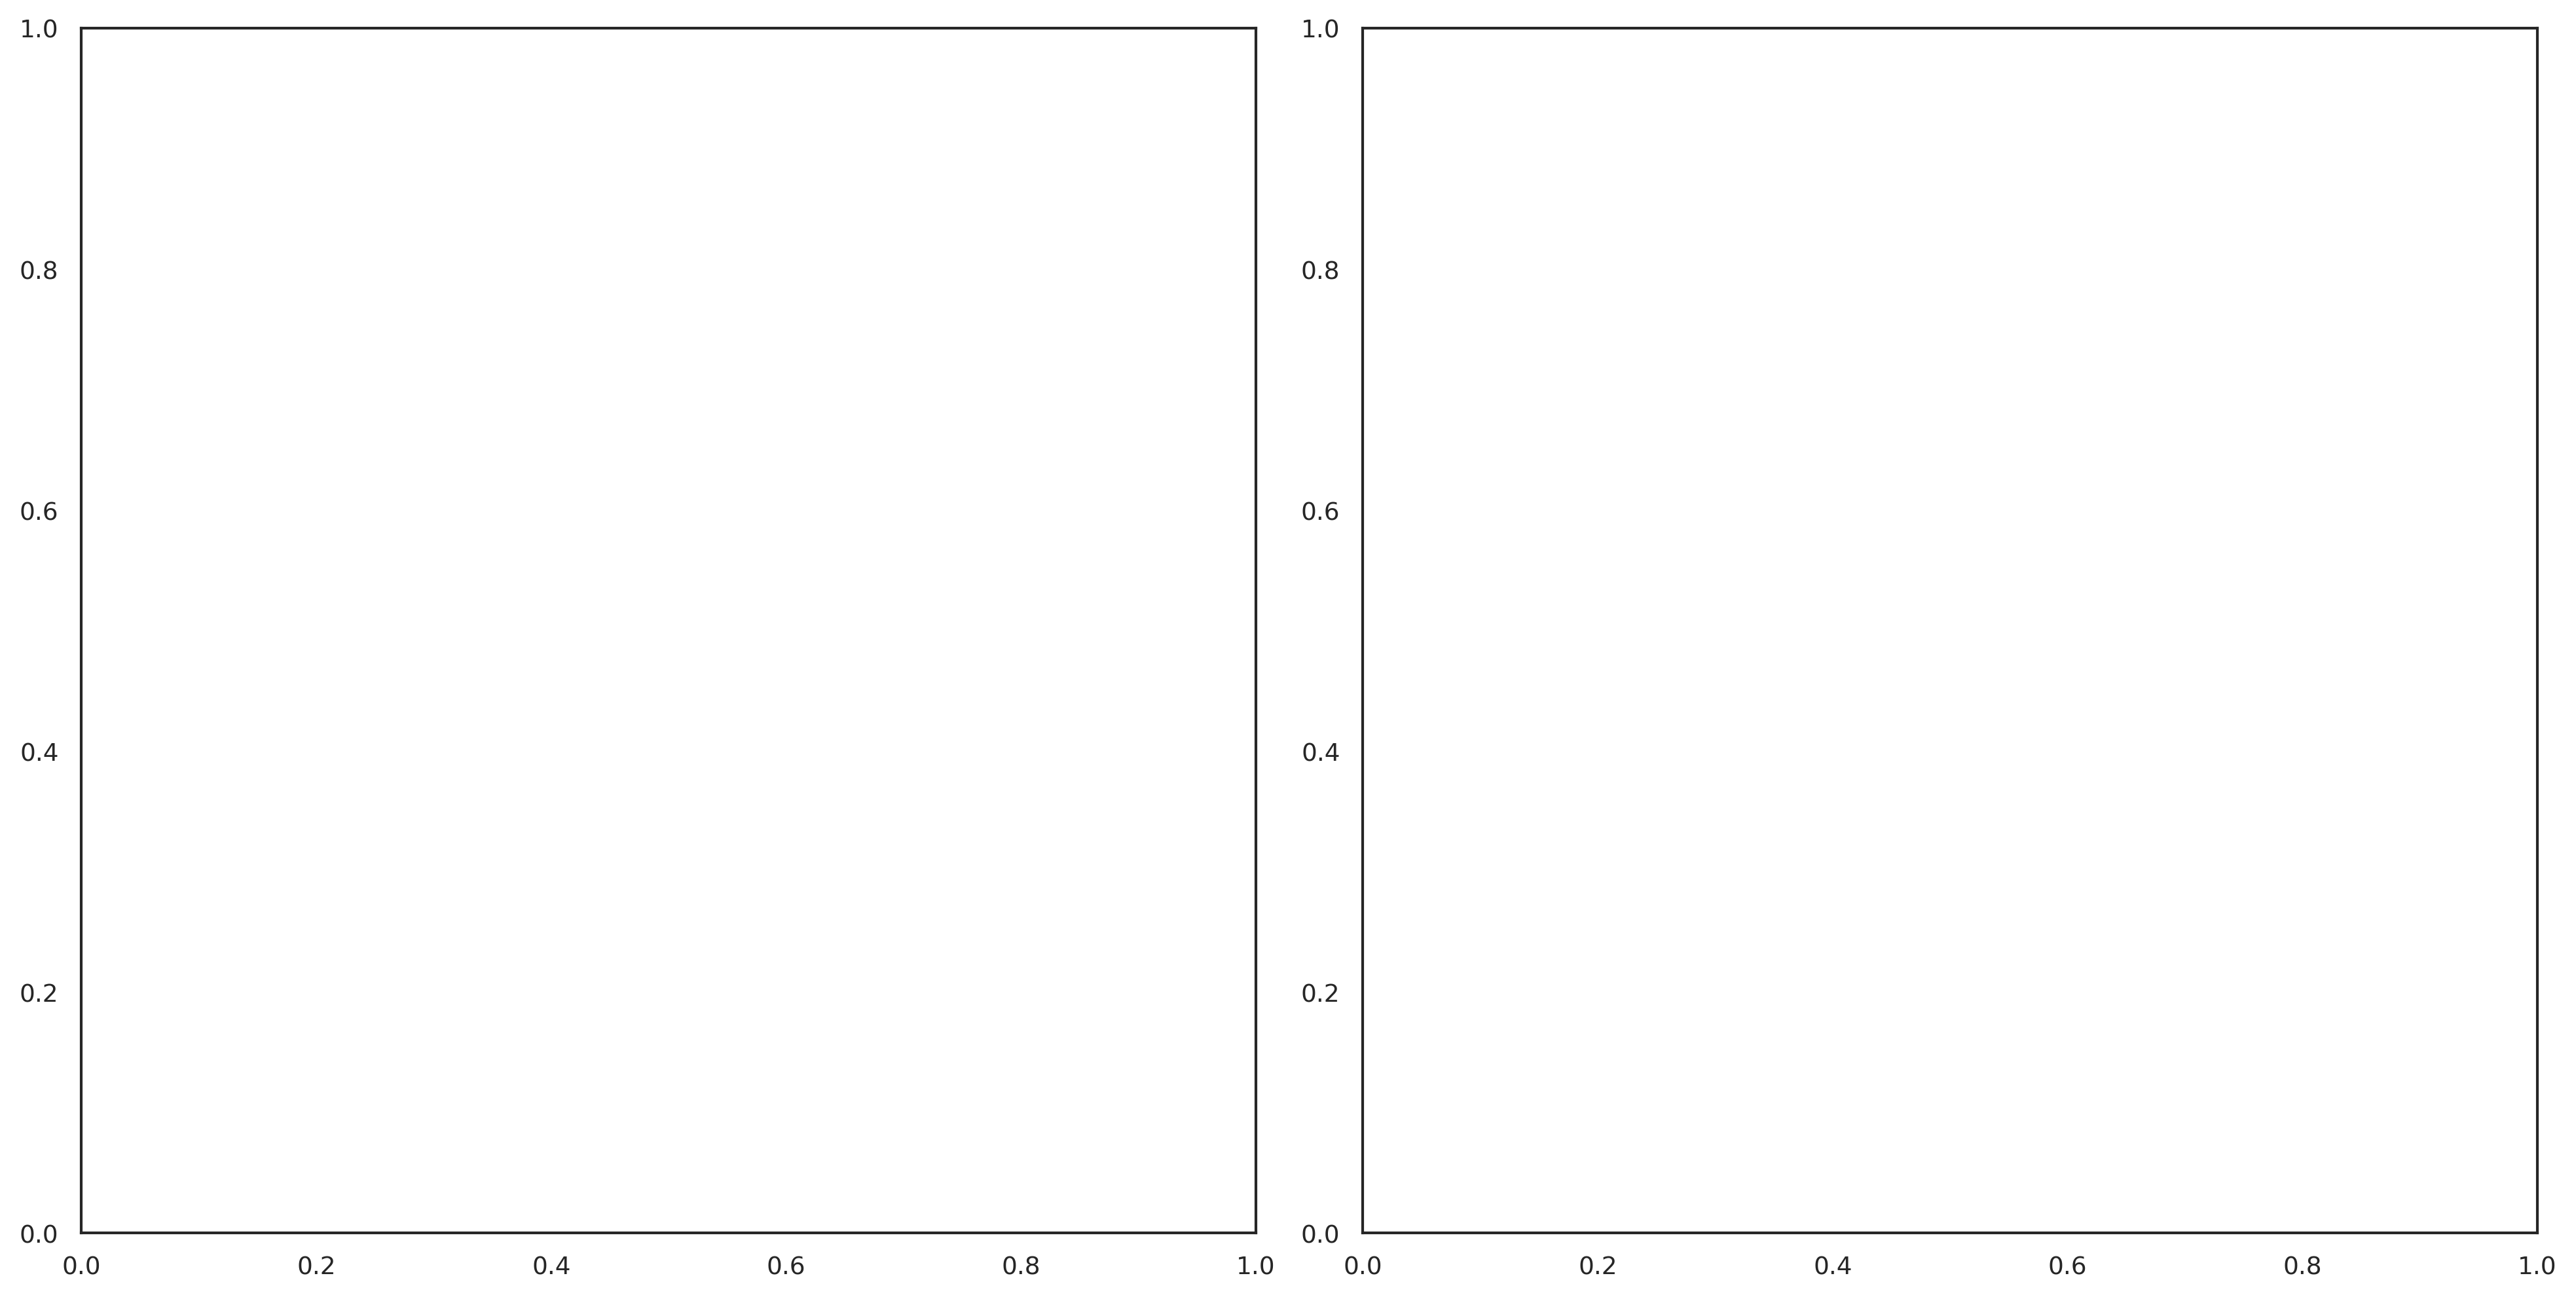

In [ ]:
"""
T-Cell Cross-Reactivity Analysis Pipeline
Multi-omic analysis of molecular mimicry between Myelin and EBV proteins
"""

# Install required packages
!pip install biopython numpy matplotlib pandas seaborn scikit-learn -q

import numpy as np
import pandas as pd
from Bio.PDB import PDBParser, Superimposer, NeighborSearch
from Bio.PDB.Polypeptide import PPBuilder
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

def upload_pdbs(label):
    """Upload multiple PDB files"""
    print(f"\n{label}")
    print("(You can select multiple files at once)")
    uploaded = files.upload()
    filenames = list(uploaded.keys())
    print(f"✓ Uploaded {len(filenames)} files")
    return filenames

def parse_structure(filename):
    """Parse PDB structure"""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('protein', filename)
    return structure

def get_ca_atoms(structure):
    """Extract CA atoms"""
    ca_atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:
                    ca_atoms.append(residue['CA'])
    return ca_atoms

def get_sequence(structure):
    """Extract protein sequence"""
    ppb = PPBuilder()
    sequence = ""
    for model in structure:
        for chain in model:
            for pp in ppb.build_peptides(chain):
                sequence += pp.get_sequence()
    return str(sequence)

def superimpose_structures(atoms1, atoms2):
    """Superimpose structures and calculate RMSD"""
    min_len = min(len(atoms1), len(atoms2))
    atoms1 = atoms1[:min_len]
    atoms2 = atoms2[:min_len]

    super_imposer = Superimposer()
    super_imposer.set_atoms(atoms1, atoms2)
    return super_imposer.rms

def calculate_sequence_identity(seq1, seq2):
    """Calculate sequence identity"""
    min_len = min(len(seq1), len(seq2))
    if min_len == 0:
        return 0.0
    matches = sum(1 for i in range(min_len) if seq1[i] == seq2[i])
    return (matches / min_len) * 100

def calculate_sequence_similarity(seq1, seq2):
    """Calculate sequence similarity with BLOSUM-like scoring"""
    # Simplified similarity groups (conservative substitutions)
    similar_groups = [
        set(['A', 'G', 'S', 'T']),  # Small
        set(['D', 'E']),  # Acidic
        set(['K', 'R', 'H']),  # Basic
        set(['F', 'Y', 'W']),  # Aromatic
        set(['I', 'L', 'V', 'M']),  # Hydrophobic
        set(['N', 'Q']),  # Amide
    ]

    min_len = min(len(seq1), len(seq2))
    if min_len == 0:
        return 0.0

    similar_count = 0
    for i in range(min_len):
        if seq1[i] == seq2[i]:
            similar_count += 1
        else:
            for group in similar_groups:
                if seq1[i] in group and seq2[i] in group:
                    similar_count += 0.5
                    break

    return (similar_count / min_len) * 100

def find_linear_epitopes(sequence, window=9):
    """Identify potential linear T-cell epitopes (9-mers for MHC-I, 13-15mers for MHC-II)"""
    epitopes = []
    for i in range(len(sequence) - window + 1):
        epitope = sequence[i:i+window]
        # Score based on hydrophobicity and charge balance
        hydrophobic = sum(1 for aa in epitope if aa in 'AILMFVPW')
        charged = sum(1 for aa in epitope if aa in 'DEKR')
        score = (hydrophobic * 0.6) + (charged * 0.4)
        epitopes.append({'sequence': epitope, 'position': i, 'score': score})
    return epitopes

def calculate_epitope_overlap(epitopes1, epitopes2, identity_threshold=0.67):
    """Calculate overlap between epitope sets"""
    overlaps = []
    for ep1 in epitopes1:
        for ep2 in epitopes2:
            # Calculate similarity between epitopes
            matches = sum(1 for i in range(len(ep1['sequence']))
                         if i < len(ep2['sequence']) and ep1['sequence'][i] == ep2['sequence'][i])
            identity = matches / len(ep1['sequence'])

            if identity >= identity_threshold:
                overlaps.append({
                    'myelin_epitope': ep1['sequence'],
                    'ebv_epitope': ep2['sequence'],
                    'identity': identity,
                    'avg_score': (ep1['score'] + ep2['score']) / 2
                })
    return overlaps

def calculate_surface_properties(structure):
    """Calculate surface-exposed residues and properties"""
    # Get all atoms
    atoms = []
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    atoms.append(atom)

    if len(atoms) < 2:
        return 0, 0, 0

    # Build neighbor search
    ns = NeighborSearch(atoms)

    # Count surface exposed residues (those with few neighbors)
    surface_residues = 0
    total_residues = 0
    charged_surface = 0

    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:
                    total_residues += 1
                    ca = residue['CA']
                    neighbors = ns.search(ca.coord, 10.0)

                    # Surface exposed if fewer neighbors
                    if len(neighbors) < 20:
                        surface_residues += 1
                        # Check if charged
                        if residue.get_resname() in ['ARG', 'LYS', 'ASP', 'GLU', 'HIS']:
                            charged_surface += 1

    surface_ratio = surface_residues / total_residues if total_residues > 0 else 0
    charged_ratio = charged_surface / surface_residues if surface_residues > 0 else 0

    return surface_ratio, charged_ratio, surface_residues

def calculate_electrostatic_similarity(struct1, struct2):
    """Calculate electrostatic surface similarity"""
    def get_charge_distribution(structure):
        charges = {'positive': 0, 'negative': 0, 'neutral': 0}
        for model in structure:
            for chain in model:
                for residue in chain:
                    resname = residue.get_resname()
                    if resname in ['ARG', 'LYS', 'HIS']:
                        charges['positive'] += 1
                    elif resname in ['ASP', 'GLU']:
                        charges['negative'] += 1
                    else:
                        charges['neutral'] += 1
        total = sum(charges.values())
        return {k: v/total if total > 0 else 0 for k, v in charges.items()}

    charge1 = get_charge_distribution(struct1)
    charge2 = get_charge_distribution(struct2)

    # Calculate similarity
    similarity = 100 - (abs(charge1['positive'] - charge2['positive']) +
                       abs(charge1['negative'] - charge2['negative'])) * 100

    return max(0, similarity)

def calculate_hydrophobic_patches(structure):
    """Identify hydrophobic surface patches"""
    hydrophobic_aas = ['ALA', 'VAL', 'ILE', 'LEU', 'MET', 'PHE', 'TRP', 'PRO']
    hydrophobic_count = 0
    total_count = 0

    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_id()[0] == ' ':
                    total_count += 1
                    if residue.get_resname() in hydrophobic_aas:
                        hydrophobic_count += 1

    return (hydrophobic_count / total_count * 100) if total_count > 0 else 0

def calculate_tcr_binding_potential(seq1, seq2, struct1, struct2):
    """Estimate T-cell receptor binding potential based on multiple factors"""
    # Surface complementarity (key for TCR binding)
    surface1, charged1, _ = calculate_surface_properties(struct1)
    surface2, charged2, _ = calculate_surface_properties(struct2)
    surface_similarity = 100 - abs(surface1 - surface2) * 100
    charge_similarity = 100 - abs(charged1 - charged2) * 100

    # Hydrophobic character (important for MHC binding)
    hydro1 = calculate_hydrophobic_patches(struct1)
    hydro2 = calculate_hydrophobic_patches(struct2)
    hydro_similarity = 100 - abs(hydro1 - hydro2)

    # Combined TCR binding score
    tcr_score = (surface_similarity * 0.4 + charge_similarity * 0.3 + hydro_similarity * 0.3)

    return tcr_score, surface_similarity, charge_similarity, hydro_similarity

def comprehensive_analysis(myelin_file, ebv_file):
    """Perform comprehensive cross-reactivity analysis"""
    try:
        # Parse structures
        myelin_struct = parse_structure(myelin_file)
        ebv_struct = parse_structure(ebv_file)

        # Get sequences
        myelin_seq = get_sequence(myelin_struct)
        ebv_seq = get_sequence(ebv_struct)

        # Basic structural similarity
        ca_myelin = get_ca_atoms(myelin_struct)
        ca_ebv = get_ca_atoms(ebv_struct)
        rmsd = superimpose_structures(ca_myelin, ca_ebv)

        # Sequence analysis
        seq_identity = calculate_sequence_identity(myelin_seq, ebv_seq)
        seq_similarity = calculate_sequence_similarity(myelin_seq, ebv_seq)

        # MHC-I epitopes (9-mers for CD8+ T cells)
        myelin_mhc1_epitopes = find_linear_epitopes(myelin_seq, window=9)
        ebv_mhc1_epitopes = find_linear_epitopes(ebv_seq, window=9)
        mhc1_overlaps = calculate_epitope_overlap(myelin_mhc1_epitopes, ebv_mhc1_epitopes)

        # MHC-II epitopes (15-mers for CD4+ T cells)
        myelin_mhc2_epitopes = find_linear_epitopes(myelin_seq, window=15)
        ebv_mhc2_epitopes = find_linear_epitopes(ebv_seq, window=15)
        mhc2_overlaps = calculate_epitope_overlap(myelin_mhc2_epitopes, ebv_mhc2_epitopes)

        # Electrostatic similarity
        electrostatic_sim = calculate_electrostatic_similarity(myelin_struct, ebv_struct)

        # TCR binding potential
        tcr_score, surface_sim, charge_sim, hydro_sim = calculate_tcr_binding_potential(
            myelin_seq, ebv_seq, myelin_struct, ebv_struct)

        return {
            'rmsd': rmsd,
            'seq_identity': seq_identity,
            'seq_similarity': seq_similarity,
            'mhc1_overlap_count': len(mhc1_overlaps),
            'mhc2_overlap_count': len(mhc2_overlaps),
            'mhc1_overlaps': mhc1_overlaps[:5],  # Top 5
            'mhc2_overlaps': mhc2_overlaps[:5],  # Top 5
            'electrostatic_sim': electrostatic_sim,
            'tcr_binding_score': tcr_score,
            'surface_similarity': surface_sim,
            'charge_similarity': charge_sim,
            'hydrophobic_similarity': hydro_sim,
            'myelin_length': len(myelin_seq),
            'ebv_length': len(ebv_seq)
        }
    except Exception as e:
        print(f"  ⚠️  Error: {str(e)}")
        return None

def calculate_cross_reactivity_score(result):
    """Calculate overall T-cell cross-reactivity risk score (0-100) with enhanced sensitivity"""
    # RMSD scoring with exponential decay for better differentiation
    # Lower RMSD = higher similarity = higher risk
    rmsd_score = 100 * np.exp(-result['rmsd'] / 2.0)  # Exponential decay

    # Sequence identity with power scaling to emphasize differences
    seq_identity_score = (result['seq_identity'] / 100) ** 0.5 * 100  # Square root scaling
    seq_similarity_score = (result['seq_similarity'] / 100) ** 0.7 * 100

    # Epitope overlap with logarithmic scaling for better differentiation
    avg_length = (result['myelin_length'] + result['ebv_length']) / 2

    # Use log scale to differentiate high overlap counts
    if result['mhc1_overlap_count'] > 0:
        mhc1_score = min(100, 20 * np.log1p(result['mhc1_overlap_count']))
    else:
        mhc1_score = 0

    if result['mhc2_overlap_count'] > 0:
        mhc2_score = min(100, 20 * np.log1p(result['mhc2_overlap_count']))
    else:
        mhc2_score = 0

    # Epitope density (overlaps per 100 residues) - critical metric
    mhc1_density = (result['mhc1_overlap_count'] / avg_length) * 100
    mhc2_density = (result['mhc2_overlap_count'] / avg_length) * 100
    epitope_density_score = min(100, (mhc1_density + mhc2_density) * 10)

    # Surface property scores with power scaling
    electrostatic_score = (result['electrostatic_sim'] / 100) ** 0.8 * 100
    tcr_score = (result['tcr_binding_score'] / 100) ** 0.6 * 100

    # Enhanced weighted combination emphasizing epitope characteristics
    cross_reactivity_score = (
        rmsd_score * 0.08 +
        seq_identity_score * 0.12 +
        seq_similarity_score * 0.08 +
        mhc1_score * 0.15 +  # CD8+ epitope count
        mhc2_score * 0.15 +  # CD4+ epitope count
        epitope_density_score * 0.20 +  # Critical: epitope density
        electrostatic_score * 0.10 +
        tcr_score * 0.12
    )

    return cross_reactivity_score

def shorten_name(name):
    """
    Shorten AlphaFold-multimer PDB filenames to readable, informative labels.
    Handles the actual naming pattern seen in the uploaded files:
    - MHCI/MHCII
    - _001 to _010 (peptide ID)
    - _myelin_ / _ebv_ / _Human_ / _EBV_ (source)
    - _REGULAR / _CTRL (condition)
    """
    # Remove .pdb and any duplicate suffixes like ' (1)'
    base = name.replace('.pdb', '').replace(' (1)', '').replace(' (2)', '')

    parts = base.split('_')

    # Determine MHC class
    if parts[0] == 'MHCI':
        mhc = 'MHC-I'
    elif parts[0] == 'MHCII':
        mhc = 'MHC-II'
    else:
        mhc = parts[0]

    # Peptide ID (001–010)
    pep_id = parts[1]  # e.g., '001', '010'

    # Source and condition
    if 'myelin' in parts:
        source = 'Myelin'
    elif 'ebv' in parts:
        source = 'EBV'
    elif 'Human' in parts:
        source = 'Human CTRL'
    elif 'EBV' in parts:
        source = 'EBV CTRL'
    else:
        source = 'Unknown'

    condition = 'Regular' if 'REGULAR' in parts else 'Control'

    # Final shortened label
    return f"{mhc}-{pep_id} ({source}, {condition})"

def visualize_results(results_df):
    """Create publish-ready multi-panel figures with properly shortened labels from real filenames."""

    # Apply shortening to both columns
    results_df['Myelin_short'] = results_df['Myelin'].apply(shorten_name)
    results_df['EBV_short'] = results_df['EBV'].apply(shorten_name)

    # Publication-ready styling
    plt.style.use('default')
    sns.set_style("white")
    sns.set_context("paper", font_scale=1.3)
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 10,
        'figure.dpi': 300
    })

    # Figure 1: Cross-reactivity heatmaps (linear + log scale)
    fig1, axes = plt.subplots(1, 2, figsize=(13, 6.5), constrained_layout=True)

    pivot_cross = results_df.pivot(index='Myelin_short', columns='EBV_short', values='Cross-Reactivity Score')

    # Linear scale
    sns.heatmap(pivot_cross, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=axes[0],
                cbar_kws={'label': 'Cross-Reactivity Score'}, vmin=0, vmax=100,
                linewidths=0.5, linecolor='lightgray')
    axes[0].set_title('Cross-Reactivity Risk Score\n(Linear Scale)')
    axes[0].set_xlabel('EBV-Derived Peptides')
    axes[0].set_ylabel('Myelin-Derived Peptides')
    axes[0].tick_params(axis='x', rotation=45, labelsize=8)
    axes[0].tick_params(axis='y', rotation=0, labelsize=8)

    # Log scale (with original values annotated)
    pivot_log = pivot_cross.applymap(lambda x: np.log10(x + 1) if pd.notnull(x) else np.nan)
    sns.heatmap(pivot_log, annot=pivot_cross.values, fmt='.1f', cmap='RdYlGn_r', ax=axes[1],
                cbar_kws={'label': 'Log₁₀(Score + 1)'}, linewidths=0.5, linecolor='lightgray')
    axes[1].set_title('Cross-Reactivity Risk Score\n(Log Scale – Enhanced Differentiation)')
    axes[1].set_xlabel('EBV-Derived Peptides')
    axes[1].set_ylabel('')
    axes[1].tick_params(axis='x', rotation=45, labelsize=8)
    axes[1].tick_params(axis='y', labelleft=False)

    fig1.suptitle('T-Cell Cross-Reactivity Risk: Myelin vs EBV Peptides',
                  fontsize=14, fontweight='bold')
    plt.show()

    # Figure 2: MHC epitope overlap heatmaps + TCR binding
    fig2, axes = plt.subplots(1, 3, figsize=(15, 5.5), constrained_layout=True)

    pivot_mhc1 = results_df.pivot(index='Myelin_short', columns='EBV_short', values='MHC-I Overlaps')
    sns.heatmap(pivot_mhc1, annot=True, fmt='d', cmap='Reds', ax=axes[0],
                cbar_kws={'label': 'Overlaps'}, linewidths=0.5, linecolor='lightgray')
    axes[0].set_title('MHC-I Epitope Overlaps\n(CD8⁺ T Cells)')
    axes[0].set_xlabel('EBV Peptides')
    axes[0].set_ylabel('Myelin Peptides')
    axes[0].tick_params(axis='x', rotation=45, labelsize=8)

    pivot_mhc2 = results_df.pivot(index='Myelin_short', columns='EBV_short', values='MHC-II Overlaps')
    sns.heatmap(pivot_mhc2, annot=True, fmt='d', cmap='Blues', ax=axes[1],
                cbar_kws={'label': 'Overlaps'}, linewidths=0.5, linecolor='lightgray')
    axes[1].set_title('MHC-II Epitope Overlaps\n(CD4⁺ T Cells)')
    axes[1].set_xlabel('EBV Peptides')
    axes[1].set_ylabel('')
    axes[1].tick_params(axis='x', rotation=45, labelsize=8)
    axes[1].tick_params(axis='y', labelleft=False)

    pivot_tcr = results_df.pivot(index='Myelin_short', columns='EBV_short', values='TCR Binding Score')
    sns.heatmap(pivot_tcr, annot=True, fmt='.1f', cmap='Purples', ax=axes[2],
                cbar_kws={'label': 'Score'}, linewidths=0.5, linecolor='lightgray')
    axes[2].set_title('TCR Binding Potential')
    axes[2].set_xlabel('EBV Peptides')
    axes[2].set_ylabel('')
    axes[2].tick_params(axis='x', rotation=45, labelsize=8)
    axes[2].tick_params(axis='y', labelleft=False)

    fig2.suptitle('Immunological Supporting Metrics', fontsize=14, fontweight='bold')
    plt.show()

    # Figure 3: Distributions, relationships, and top risks
    fig3, axes = plt.subplots(2, 2, figsize=(11, 9), constrained_layout=True)

    # Risk score distribution
    scores = results_df['Cross-Reactivity Score']
    axes[0,0].hist(scores, bins=20, color='coral', edgecolor='black', alpha=0.8)
    axes[0,0].axvline(scores.mean(), color='red', linestyle='--', linewidth=2,
                      label=f'Mean: {scores.mean():.1f}')
    axes[0,0].axvline(np.median(scores), color='navy', linestyle='--', linewidth=2,
                      label=f'Median: {np.median(scores):.1f}')
    axes[0,0].set_xlabel('Cross-Reactivity Score')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Distribution of Risk Scores')
    axes[0,0].legend()
    axes[0,0].grid(alpha=0.3)

    # Structural similarity vs risk
    scatter1 = axes[0,1].scatter(results_df['RMSD (Å)'], results_df['Cross-Reactivity Score'],
                                c=results_df['MHC-I Overlaps'], cmap='plasma',
                                edgecolor='black', alpha=0.7, s=60)
    axes[0,1].set_xlabel('RMSD (Å)')
    axes[0,1].set_ylabel('Cross-Reactivity Score')
    axes[0,1].set_yscale('log')
    axes[0,1].set_title('Structural Similarity vs Risk Score')
    axes[0,1].grid(alpha=0.3)
    cbar1 = plt.colorbar(scatter1, ax=axes[0,1])
    cbar1.set_label('MHC-I Overlaps')

    # Sequence identity vs epitope density
    results_df['Epitope_Density'] = (results_df['MHC-I Overlaps'] + results_df['MHC-II Overlaps']) / 2
    scatter2 = axes[1,0].scatter(results_df['Seq Identity (%)'], results_df['Epitope_Density'],
                                c=results_df['Cross-Reactivity Score'], cmap='RdYlGn_r',
                                edgecolor='black', alpha=0.7, s=60)
    axes[1,0].set_xlabel('Sequence Identity (%)')
    axes[1,0].set_ylabel('Average Epitope Overlaps')
    axes[1,0].set_title('Sequence Identity vs Epitope Density')
    axes[1,0].grid(alpha=0.3)
    cbar2 = plt.colorbar(scatter2, ax=axes[1,0])
    cbar2.set_label('Risk Score')

    # Top 10 risk pairs (text panel)
    axes[1,1].axis('off')
    top10 = results_df.nlargest(10, 'Cross-Reactivity Score')[
        ['Myelin_short', 'EBV_short', 'Cross-Reactivity Score', 'RMSD (Å)',
         'MHC-I Overlaps', 'MHC-II Overlaps']]

    text = "Top 10 Highest-Risk Peptide Pairs\n" + "═" * 38 + "\n\n"
    for i, row in top10.iterrows():
        risk_level = ("CRITICAL" if row['Cross-Reactivity Score'] > 70 else
                      "HIGH" if row['Cross-Reactivity Score'] > 50 else
                      "MODERATE")
        text += f"{i+1:2d}. {risk_level}\n"
        text += f"    {row['Myelin_short']}\n"
        text += f"    ↔ {row['EBV_short']}\n"
        text += f"    Score: {row['Cross-Reactivity Score']:.1f} | RMSD: {row['RMSD (Å)']:.2f} Å\n"
        text += f"    MHC-I/II: {int(row['MHC-I Overlaps'])} / {int(row['MHC-II Overlaps'])}\n\n"

    axes[1,1].text(0.05, 0.95, text, transform=axes[1,1].transAxes, fontsize=9.5,
                   verticalalignment='top', fontfamily='monospace',
                   bbox=dict(facecolor='wheat', alpha=0.8, boxstyle='round,pad=0.6'))

    fig3.suptitle('Summary Relationships and Highest-Risk Pairs', fontsize=14, fontweight='bold')
    plt.show()

    # Figure 4: Summary statistics (standalone for clarity)
    fig_summary = plt.figure(figsize=(6.5, 4.5))
    ax_summary = fig_summary.add_subplot(111)
    ax_summary.axis('off')

    p95, p75, p50 = np.percentile(scores, [95, 75, 50])
    total_pairs = len(results_df)

    summary_text = f"""SUMMARY STATISTICS
{'='*40}

Total peptide pairs analyzed: {total_pairs}

Cross-Reactivity Score
   Mean:     {scores.mean():.1f}
   Median:   {np.median(scores):.1f}
   Std dev:  {scores.std():.1f}
   95th %ile: {p95:.1f}
   75th %ile: {p75:.1f}

Risk categories
   >70 (Critical):   {len(results_df[results_df['Cross-Reactivity Score'] > 70])}
   50–70 (High):     {len(results_df[(results_df['Cross-Reactivity Score'] > 50) & (results_df['Cross-Reactivity Score'] <= 70)])}
   30–50 (Moderate): {len(results_df[(results_df['Cross-Reactivity Score'] > 30) & (results_df['Cross-Reactivity Score'] <= 50)])}
   <30 (Low):        {len(results_df[results_df['Cross-Reactivity Score'] < 30])}

Epitope overlaps (average)
   MHC-I:   {results_df['MHC-I Overlaps'].mean():.1f}
   MHC-II:  {results_df['MHC-II Overlaps'].mean():.1f}
"""
    ax_summary.text(0.05, 0.95, summary_text, transform=ax_summary.transAxes,
                    fontsize=11, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(facecolor='lightblue', alpha=0.7, boxstyle='round,pad=0.7'))

    fig_summary.suptitle('Overview of Cross-Reactivity Analysis', fontsize=13, fontweight='bold', y=0.98)
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("=" * 80)
print(" T-CELL CROSS-REACTIVITY ANALYSIS PIPELINE")
print(" Multi-Omic Molecular Mimicry Assessment")
print("=" * 80)

# Upload files
myelin_files = upload_pdbs("📁 Upload MYELIN PDB files:")
ebv_files = upload_pdbs("📁 Upload EBV PDB files:")

print(f"\n⚙️  Analyzing {len(myelin_files)} × {len(ebv_files)} = {len(myelin_files) * len(ebv_files)} pairs...")
print("\n🔬 Running multi-omic analysis:")
print("   • Structural alignment (RMSD)")
print("   • Sequence identity & similarity")
print("   • MHC-I epitope mapping (CD8+ T cells)")
print("   • MHC-II epitope mapping (CD4+ T cells)")
print("   • Electrostatic surface comparison")
print("   • TCR binding potential assessment")
print("   • Cross-reactivity risk scoring")

# Perform analyses
results = []
total = len(myelin_files) * len(ebv_files)
current = 0

for myelin_file in myelin_files:
    for ebv_file in ebv_files:
        current += 1
        print(f"\n[{current}/{total}] {myelin_file} vs {ebv_file}")

        result = comprehensive_analysis(myelin_file, ebv_file)

        if result:
            cross_reactivity = calculate_cross_reactivity_score(result)

            results.append({
                'Myelin': myelin_file,
                'EBV': ebv_file,
                'RMSD (Å)': result['rmsd'],
                'Seq Identity (%)': result['seq_identity'],
                'Seq Similarity (%)': result['seq_similarity'],
                'MHC-I Overlaps': result['mhc1_overlap_count'],
                'MHC-II Overlaps': result['mhc2_overlap_count'],
                'Electrostatic Sim (%)': result['electrostatic_sim'],
                'TCR Binding Score': result['tcr_binding_score'],
                'Surface Similarity': result['surface_similarity'],
                'Cross-Reactivity Score': cross_reactivity,
                'Epitope Density': (result['mhc1_overlap_count'] + result['mhc2_overlap_count']) /
                                  ((result['myelin_length'] + result['ebv_length']) / 2) * 100,
                'mhc1_overlaps': result['mhc1_overlaps'],
                'mhc2_overlaps': result['mhc2_overlaps']
            })

            # Risk classification with more granular categories
            if cross_reactivity > 70:
                risk = "🔴 CRITICAL RISK"
            elif cross_reactivity > 50:
                risk = "🟠 HIGH RISK"
            elif cross_reactivity > 30:
                risk = "🟡 MODERATE RISK"
            else:
                risk = "🟢 LOW RISK"

            print(f"  Cross-Reactivity Score: {cross_reactivity:.2f}/100 - {risk}")

# Create DataFrame
results_df = pd.DataFrame(results)

# Display results
print("\n" + "=" * 80)
print(" RESULTS SUMMARY")
print("=" * 80)

print(f"\n✓ Successfully analyzed {len(results_df)} pairs")

# Top 10 highest risk
print("\n" + "=" * 80)
print(" 🔴 TOP 10 HIGHEST CROSS-REACTIVITY RISK PAIRS")
print("=" * 80)

top_10 = results_df.nlargest(10, 'Cross-Reactivity Score')
for idx, row in top_10.iterrows():
    print(f"\n{row['Myelin']} ↔ {row['EBV']}")
    print(f"  Overall Risk Score: {row['Cross-Reactivity Score']:.1f}/100")
    print(f"  RMSD: {row['RMSD (Å)']:.2f} Å | Seq Identity: {row['Seq Identity (%)']:.1f}%")
    print(f"  MHC-I Overlaps: {row['MHC-I Overlaps']} | MHC-II Overlaps: {row['MHC-II Overlaps']}")
    print(f"  TCR Binding Score: {row['TCR Binding Score']:.1f}")

    # Show example epitopes
    if row['mhc1_overlaps']:
        print(f"  Example MHC-I epitope: {row['mhc1_overlaps'][0]['myelin_epitope']} ↔ {row['mhc1_overlaps'][0]['ebv_epitope']}")

# Complete table
print("\n" + "=" * 80)
print(" COMPLETE RESULTS TABLE")
print("=" * 80)
display_cols = ['Myelin', 'EBV', 'Cross-Reactivity Score', 'RMSD (Å)',
                'Seq Identity (%)', 'MHC-I Overlaps', 'MHC-II Overlaps', 'TCR Binding Score']
print(results_df[display_cols].to_string(index=False))

# Visualizations
print("\n" + "=" * 80)
print(" GENERATING VISUALIZATIONS")
print("=" * 80)
visualize_results(results_df)

print("\n✅ Analysis complete! Review the visualizations and risk scores above.")
print("\n💡 ENHANCED INTERPRETATION GUIDE:")
print("   • Score >70: CRITICAL risk - Strong molecular mimicry detected")
print("   • Score 50-70: HIGH risk - Significant cross-reactivity potential")
print("   • Score 30-50: MODERATE risk - Some similarity present")
print("   • Score <30: LOW risk - Minimal cross-reactivity concern")
print("\n📈 SCORING IMPROVEMENTS:")
print("   • Exponential RMSD decay for better sensitivity")
print("   • Logarithmic epitope scaling for high-overlap differentiation")
print("   • Epitope density metric (overlaps per 100 residues)")
print("   • Power-law transformations for sequence metrics")
print("\n🔬 KEY METRICS:")
print("   • MHC-I overlaps: CD8+ cytotoxic T-cell potential")
print("   • MHC-II overlaps: CD4+ helper T-cell potential")
print("   • Epitope density: Critical measure of mimicry concentration")
print("   • TCR binding score: Surface complementarity for T-cell recognition")